# Song prediction case study

## Setup

In [27]:
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

In [3]:
mpl.style.use("seaborn-colorblind")

In [4]:
root_path = Path().cwd().parent
raw_data_path = root_path/"data/raw/"
interim_data_path = root_path/"data/interim"

## Load data

In [5]:
df = pd.read_csv(raw_data_path/"YearPredictionMSD.txt")

In [6]:
df.shape

(515344, 91)

### Apply schema
Naming according to [authors](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD) *attribute information*  
"In simple terms, **timbre** is what makes a particular musical instrument or human voice have a different sound from another, even when they play or sing the same note" ([Wikipedia on Timbre](https://en.wikipedia.org/wiki/Timbre))

In [7]:
schema = ["year"] + [f"feat_{n}" for n in range(df.shape[1] -1)]

In [8]:
df.columns = schema

In [9]:
df.head()

,year,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     515344 non-null  int64  
 1   feat_0   515344 non-null  float64
 2   feat_1   515344 non-null  float64
 3   feat_2   515344 non-null  float64
 4   feat_3   515344 non-null  float64
 5   feat_4   515344 non-null  float64
 6   feat_5   515344 non-null  float64
 7   feat_6   515344 non-null  float64
 8   feat_7   515344 non-null  float64
 9   feat_8   515344 non-null  float64
 10  feat_9   515344 non-null  float64
 11  feat_10  515344 non-null  float64
 12  feat_11  515344 non-null  float64
 13  feat_12  515344 non-null  float64
 14  feat_13  515344 non-null  float64
 15  feat_14  515344 non-null  float64
 16  feat_15  515344 non-null  float64
 17  feat_16  515344 non-null  float64
 18  feat_17  515344 non-null  float64
 19  feat_18  515344 non-null  float64
 20  feat_19  515344 non-null  

## Split into training/test set
Splitting according to instruction given by [authors](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#) in order to avoid *producer effect*

In [11]:
train_df = df.iloc[:463715]; 

In [12]:
test_df = df.iloc[463715:]

In [13]:
train_df.shape[0] + test_df.shape[0] == df.shape[0]

True

In [14]:
dfs = [train_df, test_df]
train_df.name = "train"
test_df.name = "test"

In [15]:
for df in dfs:
    print(df.name, df.shape)

train (463715, 91)
test (51629, 91)


In [18]:
for df in dfs:
    df.to_parquet(interim_data_path/f"{df.name}.parquet", index=False)

## Exploration

In [19]:
train_df['year'].nunique()

89

In [20]:
train_df["year"].value_counts(normalize=False)

2007    35376
2006    33824
2005    31454
2008    31244
2009    27907
        ...  
1925        7
1922        6
1933        6
1924        5
2011        1
Name: year, Length: 89, dtype: int64

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

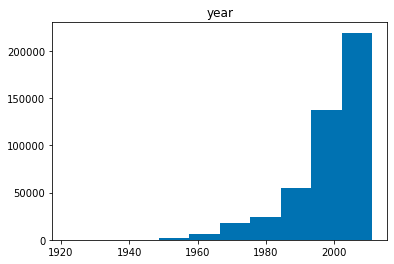

In [22]:
train_df.hist(column="year", grid=False, bins=10)

In [23]:
def classify_decade(year: int):
    if year >= 1950 and year < 1960:
        return "fifties"
    elif year >= 1960 and year < 1970:
        return "sixties"
    elif year >= 1970 and year < 1980:
        return "seventies"
    elif year >= 1980 and year < 1990:
        return "eighties"
    elif year >= 1990 and year < 2000:
        return "nineties"
    elif year >= 2000:
        return "millenium"
    else:
        return "forties or older"

In [24]:
train_df["decade"] = train_df["year"].apply(classify_decade)

In [25]:
train_df["decade"].value_counts(normalize=True)

millenium           0.598389
nineties            0.241814
eighties            0.081112
seventies           0.048196
sixties             0.022801
fifties             0.006096
forties or older    0.001591
Name: decade, dtype: float64

<AxesSubplot:title={'center':'Count of songs by decade'}>

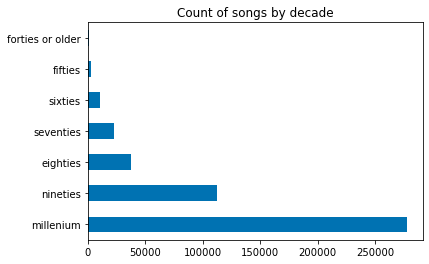

In [26]:
train_df["decade"].value_counts().plot(kind="barh", title="Count of songs by decade")

In [113]:
# Need to use librosa to visualize timbre features